# Example: Hyper-parameter Optimization
In this example, we show the examples of using hyperopt to optimize the MLP nerwork built from Pytorch.

**Features included:**

1. With implementation of early stopping.
2. With implementation of hyper-parameter tuning with hyperopt. 

In [2]:
!pip install hpsklearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 7.4 MB/s 
  Created wheel for hpsklearn: filename=hpsklearn-0.1.0-py3-none-any.whl size=23913 sha256=336e459897a8c94aa38b07d1e9f7444b8455659c4003d2e956df49f1216fc0e5
  Stored in directory: /root/.cache/pip/wheels/b2/22/23/9207fbe861f70774b563f909a415b228450bfcf863c64ac1e8
Successfully built hpsklearn


In [3]:
import pandas as pd
import numpy as np
from pandas import read_csv
import random

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix

from hyperopt import hp, tpe, fmin, Trials, space_eval
from functools import partial

from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch import Generator
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

import random

In [5]:
# set device to CUDA if available, else to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Hyper-parameter Settings

In [6]:
TEST_SIZE = 0.3
NUM_FOLDS = 5
RANDOM_STATE = 0

In [7]:
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Pytorch NN Definition

### Dataset Definition

In [8]:
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path, header=None)
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test, random_state):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size], generator=Generator().manual_seed(random_state))

### Model Definition

In [10]:
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs, hidden_layer1, hidden_layer2,):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, hidden_layer1)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(hidden_layer1, hidden_layer2)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(hidden_layer2, 1)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid() # self.act3 = Softmax(dim=1) for multi-class classification
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [11]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [12]:
# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits(n_test=TEST_SIZE, random_state=RANDOM_STATE)
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, worker_init_fn=seed_worker, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, worker_init_fn=seed_worker, shuffle=False)
    return train_dl, test_dl

In [13]:
## for cross validation
def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

## Training
Define the hyper-parameter dict PARA, and feed PARA into the train_model function.

In [14]:
# train the model
def train_model(train_dl, valid_dl, PARA, epochs=100, patience=10, early_stopping=False, cross_valid=False):
    
    ######################################
    # variables declaration for hyperopt #
    ######################################
    
    LR = PARA['lr']
    MOMENTUM = PARA['momentum']
    HIDDEN_LYR1 = PARA['hidden_layer1']
    HIDDEN_LYR2 = PARA['hidden_layer2']
    
    ###########################################
    # variables declaration for early stopping#
    ###########################################
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize for early stopping
    epochs_no_improve = 0
    min_val_loss = np.Inf
    early_stop_detected = False
    
    ###############################
    # model related implementation#
    ###############################
    
    # define the model
    model = MLP(60, HIDDEN_LYR1, HIDDEN_LYR2)
    if cross_valid:
        model.apply(reset_weights)
        
    # define the optimization
    criterion = BCELoss() # CrossEntropyLoss() for multi-class classification
    optimizer = SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    
    # enumerate epochs
    for epoch in range(1, epochs+1):
        
        # prepare model for training
        model.train() 
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            y_pred_train = model(inputs)
            # calculate loss
            loss = criterion(y_pred_train, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        # print training/validation statistics 
        # calculate average loss over an epoch 
        train_loss = np.average(train_losses)
        avg_train_losses.append(train_loss)
        
        # clear lists to track next epoch
        train_losses = []
        
        epoch_len = len(str(epochs))
        
        if valid_dl is None:
        
            print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                             f'train_loss: {train_loss:.5f} ')
            
            print(print_msg)
        
        # process valid set if it is available
        else:
            # prepare model for evaluation
            model.eval() 

            for inputs, targets in valid_dl:
                # forward pass: compute predicted outputs by passing inputs to the model
                y_pred_valid = model(inputs)
                # calculate the loss
                loss = criterion(y_pred_valid, targets)
                # record validation loss
                valid_losses.append(loss.item())

            # print training/validation statistics 
            # calculate average loss over an epoch            
            valid_loss = np.average(valid_losses)
            avg_valid_losses.append(valid_loss)

            print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.5f} ' +
                         f'valid_loss: {valid_loss:.5f}')

            # print(print_msg)

            # clear lists to track next epoch
            valid_losses = []

            if early_stopping:

                # early_stopping needs the validation loss to check if it has decresed
                if valid_loss < min_val_loss:
                    epochs_no_improve = 0
                    min_val_loss = valid_loss
                else:
                    epochs_no_improve += 1

                if epoch > 5 and epochs_no_improve==patience:
                    early_stop_detected = True
                    break
                
    #     if early_stopping:
    #         if early_stop_detected:
    #             print(f'  Early stopping at epoch: {epoch}!' )
    #             print(f'  Stopped with valid loss={valid_loss:.5f}')
    #         else:
    #             print(f'  No early stopping. Finish training until epoch: {epoch}!' )
    #             print(f'  Stopped with valid loss={valid_loss:.5f}')    

    return model, avg_train_losses, avg_valid_losses

## Evaluation

In [15]:
# evaluate the model
def evaluate_model(model, test_dl):
    predictions, actuals = list(), list()
    # prep model for evaluation
    model.eval() 
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        y_proba = model(inputs)
        # retrieve numpy array
        y_proba = y_proba.detach().numpy()
        # round to class values
        y_pred = y_proba.round()
        # extract true label
        y_true = targets.numpy()
        y_true = y_true.reshape((len(y_true), 1))
        # store
        predictions.append(y_pred)
        actuals.append(y_true)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate f1-score
    f1 = f1_score(actuals, predictions)
    return f1, actuals, predictions

In [16]:
# make a class prediction for one row of data
def predict(row, model):
    # make prediction
    y_proba = model(row)
    # retrieve numpy array
    y_proba = y_proba.detach().numpy()
    y_pred = y_proba.round() # np.argmax(y_proba) for multi-class classification
    return y_proba, y_pred

## Objective Function Definition
Return the metric to evaluate the hyper-paramter settings.

In [17]:
def objective(params):
    
    print ('Params testing: ', params)
    print ('\n ')
    
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)
    scores = []

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_dl.dataset)):

        random.shuffle(train_ids)
        
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
                          train_dl.dataset, 
                          batch_size=10, sampler=train_subsampler)
        validloader = torch.utils.data.DataLoader(
                          train_dl.dataset,
                          batch_size=10, sampler=valid_subsampler)
    
        # Train Model
        model, avg_train_losses, avg_valid_losses = train_model(train_dl=trainloader, 
                                                                valid_dl=validloader, 
                                                                PARA=params,
                                                                early_stopping=True, 
                                                                cross_valid=True)
     
        #predict the test set 
        f1, _, _ = evaluate_model(model, validloader)
        # print('F1 score: %.3f' % f1)
        scores.append(f1)
        
    mean = round(sum(scores)/len(scores), 3)
    print('Mean F1 score from cross validation: %.3f' % mean)
    
    return -mean

## Hyper-parameter Optimization
Here we use TPE from hyperopt to optimize the hyper-parameters.

In [18]:
# prepare the data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))

# hyper-parameter optimization with hyperopt
# define space
nn_space = {'lr' : hp.choice('lr', np.logspace(-2, -4, 3)),
            'momentum': hp.choice('momentum', [0.3,0.5,0.8,0.9]),
            'hidden_layer1': hp.choice('hidden_layer1', [10,20,30]),
            'hidden_layer2': hp.choice('hidden_layer2', [5,8,10,20]),
           }

trials = Trials()

# Run Hyper Optimization
para_best = fmin(
    fn=objective,
    space=nn_space,
    algo=tpe.suggest,
    return_argmin=False,
    verbose=True,
    trials=trials,
    max_evals=20,  # Max Number of Iterations
    rstate=np.random.RandomState(0)
)

print("Best Parameters")
print(para_best)

146 62
Params testing: 
{'hidden_layer1': 10, 'hidden_layer2': 5, 'lr': 0.0001, 'momentum': 0.3}
Mean F1 score from cross validation: 0.292
Params testing: 
{'hidden_layer1': 10, 'hidden_layer2': 20, 'lr': 0.001, 'momentum': 0.9}
Mean F1 score from cross validation: 0.425
Params testing: 
{'hidden_layer1': 10, 'hidden_layer2': 8, 'lr': 0.0001, 'momentum': 0.5}
Mean F1 score from cross validation: 0.324
Params testing: 
{'hidden_layer1': 10, 'hidden_layer2': 20, 'lr': 0.001, 'momentum': 0.3}
Mean F1 score from cross validation: 0.414
Params testing: 
{'hidden_layer1': 20, 'hidden_layer2': 20, 'lr': 0.001, 'momentum': 0.5}
Mean F1 score from cross validation: 0.432
Params testing: 
{'hidden_layer1': 10, 'hidden_layer2': 20, 'lr': 0.0001, 'momentum': 0.5}
Mean F1 score from cross validation: 0.406
Params testing: 
{'hidden_layer1': 20, 'hidden_layer2': 10, 'lr': 0.0001, 'momentum': 0.5}
Mean F1 score from cross validation: 0.525
Params testing: 
{'hidden_layer1': 20, 'hidden_layer2': 8, '

### Print the best hyper-parameter settings

In [19]:
para_best

{'hidden_layer1': 20, 'hidden_layer2': 8, 'lr': 0.01, 'momentum': 0.3}

## Traing with the best hyper-paramters

[  1/100] train_loss: 0.76309 
[  2/100] train_loss: 0.73123 
[  3/100] train_loss: 0.70712 
[  4/100] train_loss: 0.69297 
[  5/100] train_loss: 0.68178 
[  6/100] train_loss: 0.67785 
[  7/100] train_loss: 0.67145 
[  8/100] train_loss: 0.66812 
[  9/100] train_loss: 0.65893 
[ 10/100] train_loss: 0.66210 
[ 11/100] train_loss: 0.65828 
[ 12/100] train_loss: 0.64855 
[ 13/100] train_loss: 0.64858 
[ 14/100] train_loss: 0.64308 
[ 15/100] train_loss: 0.64468 
[ 16/100] train_loss: 0.63519 
[ 17/100] train_loss: 0.63599 
[ 18/100] train_loss: 0.63431 
[ 19/100] train_loss: 0.63311 
[ 20/100] train_loss: 0.63026 
[ 21/100] train_loss: 0.62856 
[ 22/100] train_loss: 0.63361 
[ 23/100] train_loss: 0.62589 
[ 24/100] train_loss: 0.62787 
[ 25/100] train_loss: 0.62276 
[ 26/100] train_loss: 0.62105 
[ 27/100] train_loss: 0.62328 
[ 28/100] train_loss: 0.61622 
[ 29/100] train_loss: 0.61403 
[ 30/100] train_loss: 0.61485 
[ 31/100] train_loss: 0.61106 
[ 32/100] train_loss: 0.61461 
[ 33/100

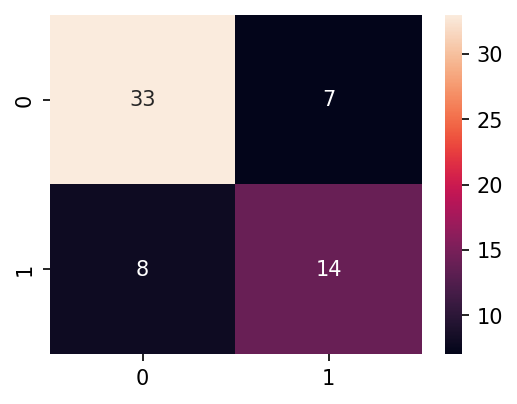

Predicted class=1 (y_proba=0.746) vs (Actual class=1)


In [20]:
# train the model
model, avg_train_losses, avg_valid_losses = train_model(train_dl=train_dl, 
                                                        valid_dl=None, 
                                                        PARA=para_best,
                                                        early_stopping=True)
# evaluate the model
F1_test, actuals_test, predictions_test = evaluate_model(model, test_dl)

print(f"Test F1-Score: {round(F1_test, 3)}")

# Show summary of performance
cf_matrix = confusion_matrix(actuals_test, predictions_test)

plt.figure(dpi=150, figsize=(4, 3))
sns.heatmap(cf_matrix, annot=True)
plt.show()

# make a single prediction (expect class=1)
for inputs, targets in test_dl:  
    sample_X_test = inputs[0] 
    sample_y_test = targets[0]
y_proba, y_pred = predict(sample_X_test, model)
print('Predicted class=%d (y_proba=%.3f) vs (Actual class=%d)' % (y_pred, y_proba, sample_y_test.numpy()[0]))

---

## Reference

1. https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
2. https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
3. https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb